<a href="https://colab.research.google.com/github/StefanoBergia/DataSpaces_2020-2021-Tesina/blob/master/Tesina_Data_Spaces_Stefano_Bergia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Algerian Forest Fire

#Introduction

The aim of this report is to analize the Algerian Forest Fires dataset available on UCI website http://archive.ics.uci.edu/ml/datasets/Algerian+Forest+Fires+Dataset++# 
and applying some machine learning algorithms on this set of data in order to predict the risk of a forest fire in certain conditions.

The Dataset contains 244 record collected from two region of algeria defined by the following attrubutes:

* Date: date in which data for this record was gathered, all data refers to a period of time from june to september 2012 (this attribute is irrelevant in the context of this analisys so it will be ignored)
* Temperature: max temperature at noon in Celsius degrees: 22 to 42
*	RH: Relative Humidity in %: 21 to 90
*	Ws: Wind speed in km/h: 6 to 29
*	Rain: mm of rain in a day: 0 to 16.8

> The following attributes are indexes computed following the Fire Weather index standard and directly depend on previous attributes
(https://cwfis.cfs.nrcan.gc.ca/background/summary/fwi)
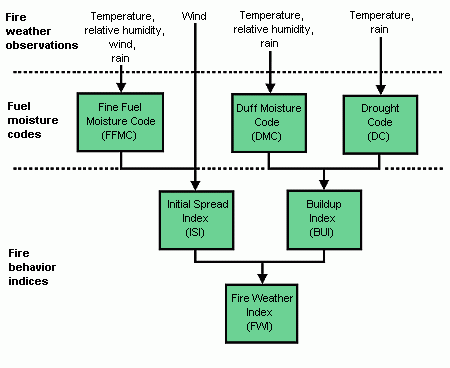


*	FFMC: The Fine Fuel Moisture Code (FFMC) is a numeric rating of the moisture content of litter and other cured fine fuels. This code is an indicator of the relative ease of ignition and the flammability of fine fuel. From 28.6 to 92.5
* DMC: The Duff Moisture Code (DMC) is a numeric rating of the average moisture content of loosely compacted organic layers of moderate depth. This code gives an indication of fuel consumption in moderate duff layers and medium-size woody material. From 1.1 to 65.9
*	DC: The Drought Code (DC) is a numeric rating of the average moisture content of deep, compact organic layers. This code is a useful indicator of seasonal drought effects on forest fuels and the amount of smoldering in deep duff layers and large logs. From 7 to 220.4
*	ISI: The Initial Spread Index (ISI) is a numeric rating of the expected rate of fire spread. It is based on wind speed and FFMC. Like the rest of the FWI system components, ISI does not take fuel type into account. Actual spread rates vary between fuel types at the same ISI. From 0 to 18.5
*	BUI: The Buildup Index (BUI) is a numeric rating of the total amount of fuel available for combustion. It is based on the DMC and the DC. The BUI is generally less than twice the DMC value, and moisture in the DMC layer is expected to help prevent burning in material deeper down in the available fuel. From 1.1 to 68
*	FWI: The Fire Weather Index (FWI) is a numeric rating of fire intensity. It is based on the ISI and the BUI, and is used as a general index of fire danger throughout the forested areas of Algeria. From 0 to 31.1
	
* Classes: it's the target attribute, it canbe 'fire' or 'not fire'

In [ ]:
import os
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold,learning_curve
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, confusion_matrix,roc_curve, auc,accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import plot_roc_curve,roc_auc_score
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn import tree
 
import warnings
warnings.filterwarnings('ignore')
 
 
! rm -r 'DataSpaces_2020-2021-Tesina'
if not os.path.isdir('./DataSpaces_2020-2021-Tesina'):
  !git clone https://github.com/StefanoBergia/DataSpaces_2020-2021-Tesina.git
 
dataSetPath= './DataSpaces_2020-2021-Tesina'
fire_color='#ff7f0e'
not_fire_color='#1f77b4'
SEED=16

rm: cannot remove 'DataSpaces_2020-2021-Tesina': No such file or directory


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.



Cloning into 'DataSpaces_2020-2021-Tesina'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 13 (delta 5), reused 12 (delta 4), pack-reused 0
Unpacking objects: 100% (13/13), done.


#Loading Dataset

In [ ]:
# load the dataset

#Bejaia region
dfBej = pd.read_csv(dataSetPath+"/Bejaia_Region.csv")
#Sidi Bel Abbes region
dfSid = pd.read_csv(dataSetPath+"/Sidi-Bel-Abbes_Region.csv")
dfSid = dfSid.dropna(how='any',axis=0) 
#Complete dataset
df=dfBej.append(dfSid)

#trim spaces and remove useless fields
df.columns = [s.replace(" ", "") for s in df.columns]
df['Classes'] = df['Classes'].str.strip()
df = df.drop(["day"], axis=1)
df = df.drop(["month"], axis=1)
df = df.drop(["year"], axis=1)

print("The dataset has %d rows and %d columns." % df.shape)

print("There are " + ("some" if dfSid.isnull().values.any() else "no")  + " null/missing values in the dataset.")


The dataset has 243 rows and 11 columns.
There are no null/missing values in the dataset.


# Data Exploration

here some raw statistics are listed.
25% refers to 25 percentile (which is the value before which 25% of the sample are located), 50% to the median and 75% to the 75 percentile

In [ ]:
df.head(10)

,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
0,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire
1,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire
2,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire
3,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0,not fire
4,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,not fire
5,31,67,14,0.0,82.6,5.8,22.2,3.1,7.0,2.5,fire
6,33,54,13,0.0,88.2,9.9,30.5,6.4,10.9,7.2,fire
7,30,73,15,0.0,86.6,12.1,38.3,5.6,13.5,7.1,fire
8,25,88,13,0.2,52.9,7.9,38.8,0.4,10.5,0.3,not fire
9,28,79,12,0.0,73.2,9.5,46.3,1.3,12.6,0.9,not fire


In [ ]:
pd.set_option("display.precision", 2)
df.describe()

,Temperature,RH,Ws,Rain,FFMC,DMC,ISI,BUI
count,243.00,243.00,243.00,243.00,243.00,243.00,243.00,243.00
mean,32.15,62.04,15.49,0.76,77.84,14.68,4.74,16.69
std,3.63,14.83,2.81,2.00,14.35,12.39,4.15,14.23
min,22.00,21.00,6.00,0.00,28.60,0.70,0.00,1.10
25%,30.00,52.50,14.00,0.00,71.85,5.80,1.40,6.00
50%,32.00,63.00,15.00,0.00,83.30,11.30,3.50,12.40
75%,35.00,73.50,17.00,0.50,88.30,20.80,7.25,22.65
max,42.00,90.00,29.00,16.80,96.00,65.90,19.00,68.00


## Distribution of target class

In [ ]:
count = df["Classes"].value_counts()

fig = go.Figure(data=[
    go.Bar(name='not fire', x=['not fire'], y=[count["not fire"]],marker_color=not_fire_color),
    go.Bar(name='fire', x=['fire'], y=[count["fire"]],marker_color=fire_color)

])
fig.update_layout(
    width=500,
    height=500)
fig.show()


In [ ]:
fire_perc = count['fire'] * 100 / count.values.sum()
print("Fire percentage is %.3f%%." % fire_perc)

Fire percentage is 56.379%.


Since the two classes are quite balanced there is no need to use oversampling tecniques 

## Distribution per attribute

In [ ]:
# split dataset according to target attribute
fire = df[df["Classes"] == 'fire']
not_fire = df[df["Classes"] == 'not fire']

features=df.columns.drop("Classes")

In [ ]:
grid = make_subplots(rows=4, cols=3,subplot_titles=np.append(features[0:9].to_numpy(),["-",features[9]]))

#create histograms traces
fig = go.Figure()
showl=True

for i, col in enumerate(features):
  col=col
  if i>0:
    showl=False
  if i==9 :
    i=10
  grid.add_trace(go.Histogram(
        x=not_fire[col],
        name='not fire',
        marker_color=not_fire_color,
        showlegend=showl
    ),int(i/3)+1,i%3+1
  )
  grid.add_trace(go.Histogram(
        x=fire[col],
        name='fire',
        marker_color=fire_color,
        showlegend=showl
    ),int(i/3)+1,i%3+1
  )
grid.update_layout( height=1600,width=1500)
grid.show()

From these charts we can see that the number of fires for the  Temperature, Relative humidity and wind speed features follow a sort of gaussian distribution, in particular the probability of a fire is higher around the average value of these features (32.15 °C,	62% 	15.5 Km/h).
Rain Attribute seems not to be too informative because all of the fires were of course recorded with no (or very little) rain. 
Other parameters directly depends on these raw measurements, of course we expect them to be correlated and we have to decide which are the most useful in order to predict a fire.
in particular FFMC and ISI seems to work with a "sort of threshold" which means that after a certain value all samples are categorized as fire.
The Remaining features all seem to follow a similar distrubution which is a gaussian skewed to the left but with different scales for each attribute.

## Box Plot

Here the box plots for each feature are listed. A box plot visualizes the following statistics:

* median
* the first quartile (Q1) and the third quartile (Q3) building the interquartile range (IQR)
* the lower fence (Q1 - 1.5 IQR) and the upper fence (Q3 + 1.5 IQR)
* the maximum and the minimum value

Each quartile corresponds to an increase of 25 for the percentile with respect to the previous one.

The Inter Quartile Range corresponds to 50 percentile


In [ ]:

showl=True

grid = make_subplots(rows=4, cols=3,subplot_titles=np.append(features[0:9].to_numpy(),["-",features[9]]))
for i, col in enumerate(features):
  col=col
  if i>0:
    showl=False
  if i==9:
    i=10
  grid.add_trace(go.Box(
        x=not_fire[col],
        name='not fire',
        marker_color=not_fire_color,
        showlegend=showl,
        orientation='h'
    ),int(i/3)+1,i%3+1
  )
  grid.add_trace(go.Box(
        x=fire[col],
        name='fire',
        marker_color=fire_color,
        showlegend=showl,
        orientation='h'
    ),int(i/3)+1,i%3+1
  )
grid.update_layout(height=1600,width=1500)
grid.show()

The boxplots highlight the previous observation. 
The first features (Temperature, Relative Humidity, and Wind Speed) are more overlapped, while others have a clear threshold between fire and not fire class. So it should b possible to apply dimensionality reduction tecniques and work with less infromation.

In [ ]:
# splitting the dataset into feature vectors and the target variable
df_y = df["Classes"]
df_X = df.drop(["Classes"], axis=1)

df_X['DC']=pd.to_numeric(df_X['DC'])
df_X['FWI']=pd.to_numeric(df_X['FWI'])

## Correlation Matrix

In order to investigate the pair-wise correlations between two variables X and Y, it is usefull to use the Pearson correlation. Let σX,σY be the standard deviation of X,Y and cov(X,Y)=E[(X−E[X])(Y−E[Y])]. Then we can define the Pearson correlation as the following:
ρX,Y=cov(X,Y)σXσY.

To visualize these correlations we use a heatmap plot, in which high correlations are coloured more to the teallow and lower ones more to the violet.

A value colse to one means that the two features can be associated to a linear correlation, meaning that if the average of the samples from one feature increases also the average of the sample from the other distribution increases. The opposite if the correlation is close to -1.

In [ ]:
corr = df_X.corr()
trace = go.Heatmap(z=corr.values.tolist(), x=corr.columns, y=corr.columns)
data=[trace]
layout = go.Layout(
    title='Heatmap of pairwise correlation of the features',
    autosize=False,
    width=650,
    height=600,
    yaxis=go.layout.YAxis(automargin=True),
    xaxis=dict(tickangle=40),
    margin=go.layout.Margin(l=0, r=200, b=200, t=80)
)


fig = go.Figure(data=data, layout=layout)
fig.show()

As already implied bu the relation between the FWI indexes and the raw data, we can see that there is an highly positive correlation between the indexes and the temperature and between the indexes with each other. We can also see that the indexes are negatively correlated with the relative humidity.
This suggest that it will be possible to reduce dimensionality of the problem by ignoring the fwi indexes given that many features seems to model the same aspect of the event.

 ## Data normalization
 Another thing to notice is the fact that the fetures have different ranges, so before proceedng it's better to apply min max noralization in oder to have all features in the same scale.
 Min max normalization is applieg because in the original dataset all values are positive and it is necessary to keep this property after normalization.

In [ ]:
df_X_n = (df_X-df_X.min())/(df_X.max()-df_X.min())
df_X_n['Classes']=df_y
print(df_X_n)

fire = df_X_n[df_X_n["Classes"] == 'fire']
not_fire = df_X_n[df_X_n["Classes"] == 'not fire']

     Temperature    RH    Ws      Rain  ...       ISI       BUI       FWI   Classes
0           0.35  0.52  0.52  0.00e+00  ...  6.84e-02  3.44e-02  1.61e-02  not fire
1           0.35  0.58  0.30  7.74e-02  ...  5.26e-02  4.19e-02  1.29e-02  not fire
2           0.20  0.88  0.70  7.80e-01  ...  1.58e-02  2.39e-02  3.22e-03  not fire
3           0.15  0.99  0.30  1.49e-01  ...  0.00e+00  8.97e-03  0.00e+00  not fire
4           0.25  0.81  0.43  0.00e+00  ...  6.32e-02  4.19e-02  1.61e-02  not fire
..           ...   ...   ...       ...  ...       ...       ...       ...       ...
117         0.40  0.64  0.35  0.00e+00  ...  2.37e-01  2.36e-01  2.09e-01      fire
118         0.30  0.96  0.39  2.62e-01  ...  5.26e-03  7.62e-02  0.00e+00  not fire
119         0.25  0.96  1.00  2.98e-02  ...  2.11e-02  3.44e-02  6.43e-03  not fire
120         0.10  0.48  0.52  5.95e-03  ...  8.95e-02  5.98e-02  2.25e-02  not fire
121         0.10  0.62  0.39  1.19e-02  ...  6.32e-02  5.53e-02  1.61e-02  n

#Split in training & testing sets

to create a common baseline between all models, an hold out stratified testing set is created by removing 20% of the record from the dataset keeping the relative proportion for fire/not fire labels. 
All algorithms from now on will be trained on the same training set and tested on the same testing set.

In [ ]:
fire_train,fire_test= train_test_split(fire, test_size=0.2,random_state=16)
not_fire_train,not_fire_test= train_test_split(not_fire, test_size=0.2,random_state=16)

df_train=fire_train.append(not_fire_train)
df_test=fire_test.append(not_fire_test)

df_train_y = df_train["Classes"]
df_test_y = df_test["Classes"]

df_train_X = df_train.drop(["Classes"], axis=1)
df_test_X = df_test.drop(["Classes"], axis=1)


# PCA

Principal Component Analysis is a linear transformation algorithm whose purpose is to project data sampled in an high dimensional space onto a lower dimensional space, so that they can be represented in an easier and more meaningful way and avoid the so called "Curse of Dimensionality".

The Curse of dimensionality affects distances between points in high dimensional spaces. The greater the number of dimensions (features) the less meaningful distance measures become. This happens beacuse point density in n-dimensional spaces gets lower and lower as the number of dimension increases and if we fix a certain n-dimansional Volume and a density, the number of points in the volume needed to keep that density grows exponentially. 

The output of this procedure are the so called "principal components", one for each dimension of the target space.
The pricipal components are linear combinations of original features and are orthogonal with each other, as together they generate the target space. Each PC is composed by two element, a loading (which is a versor) and a score which represents the amount of variance along the direction of the loading. If we rank all principal components by their varince and take the first n (where n is the dimension of the target space) we obtain the base vectors of the target space.

The PCA algorithms works as follows:
* center data by subtracting to each attrubute the average value for that features
* compute the sample-covariance matrix, a dxd symmetrical matrix (d is the original number of features) in which each cell i,j of the matrix contains the covariance between feature i and feature j
* Compute eigenvectors and eigenvalues of the sample covariance matrix (solve det (COV – λI) = 0 to find the eigenvalues and then plug them in the equation  det (COV – λI)V = 0 to find the corresponding eigenvectors)
*  Sort eigenvectors with respect to their eigenvalues
* build the  projection matrix W by putting the top n (n dimension of the target space) eigenvectors into the columns of W
* transform the dataset X by multiplying it with W (W is a projection mattrix)

Two important measures with respect to PCA are the individual explained variance and the comulative explained variance:
 the individual explained variance is the ratio between the variance of that principal component and the total variance, the comulative explained variance for PCi is the sum of all previous PC variance up until i (included)
The higher the cumulative explained variance the better is our representation because it will introduce fewer errors (projecting on a lower dimensional space  means that points that originally are far apart could become closer and possibly be classified, by algorithms applied on projected data, with the same label and this could be an error )

In [ ]:
pca=PCA(random_state=SEED)
df_train_X_pca = pca.fit_transform(df_train_X)

tot = sum(pca.explained_variance_) # total explained variance of all principal components
var_exp = [(i / tot) * 100 for i in sorted(pca.explained_variance_, reverse=True)] # individual explained variance
cum_var_exp = np.cumsum(var_exp) # cumulative explained variance


In [ ]:
trace_cum_var_exp = go.Bar(
    x=list(range(1, len(cum_var_exp) + 1)), 
    y=var_exp,
    name="individual explained variance",
)
trace_ind_var_exp = go.Scatter(
    x=list(range(1, len(cum_var_exp) + 1)),
    y=cum_var_exp,
    mode='lines+markers',
    name="cumulative explained variance",
    line=dict(
        shape='hv',
    ))
data = [trace_cum_var_exp, trace_ind_var_exp]
layout = go.Layout(
    title='Individual and Cumulative Explained Variance',
    autosize=True,
    yaxis=dict(
        title='percentage of explained variance',
    ),
    xaxis=dict(
        title="principal components",
        dtick=1,
    ),
    legend=dict(
        x=0,
        y=1,
    ),
)
fig = go.Figure(data=data, layout=layout)
fig.show()

As expected, applying  PCA we obtained that most of the variance is explained by the first principal components, in particular the first 3 together accounts for the 87,64% of the total variance. That's because most of the parameters ar correlated to each other and they basically represent the same aspect of the event, just from different point of view. 

In [ ]:
n_components = 2
df_train_X_pca = np.dot(df_train_X.values, pca.components_[:n_components,:].T)
df_train_X_pca = pd.DataFrame(df_train_X_pca, columns=["PC#%d" % (x + 1) for x in range(n_components)])

df_test_X_pca = np.dot(df_test_X.values, pca.components_[:n_components,:].T)
df_test_X_pca = pd.DataFrame(df_test_X_pca, columns=["PC#%d" % (x + 1) for x in range(n_components)])

### Scatter Plot with 3 principal components

In [ ]:

df = px.data.iris()
pca = PCA(n_components=3)
components = pca.fit_transform(df_train_X)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=df_train_y,
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
    color_discrete_sequence =[fire_color,not_fire_color]
)
fig.update_layout(width=600, height=500)
fig.show()

As we can see from the scatterPlot, projecting data on a 3d space geneated by the first 3 principal component yelds quite good results. 
The two sets (fire/not fire) are easily disinguishable, leaving only an incertainty region when the two touches which amounts to about 13% of the data. A linear classifier with an appropriate margin should perform quite good on this space (SVM will be discussed later).

## Biplot with first 2 components



In [ ]:
pca = PCA(n_components=2)
components = pca.fit_transform(df_train_X)

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
fig = px.scatter(components, x=0, y=1,
                 color=df_train_y,
                 color_discrete_sequence =[fire_color,not_fire_color])

for i, feature in enumerate(features):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, 0],
        y1=loadings[i, 1]
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
    )
fig.show()


The previous observations still hold even with only in two dimensions, the two sets are still quite separable, so it would theoretically be possibe to use just the first two principal components.

Moreover if we look at the loading vectors we can see that the closest features to the principal components are FWI (close to PC0) and Ws (close to PC1), this means that these two features are determined for the most part to only one principal component, meaning that they probably represent a really similar concept.
This was to be expectd as FWI is a measure that aggregates all raw features as explained before.

# Model selection

Data exploration yelded some interesting results.
In particular correlation matrix showed that FWI measure are all correlated with each other, so it is reasonable to ignore FWI attribute and use only the raw features.

On the contrary PCA seems to suggests that refined features make a better job at explaining variance and therefore it can be interesting to use principal components in order to solve classification task

In the following paragraphs various models are presented, for each of them three scenarios will be analyzed:

* keep only raw features (temperature,RH,Ws,Rain) and drop the others

* project data in 2d -principal component space

* use all the features 

All models will be trained on the same training set and compared computing the accuracy score on the same test-set and the confusion matrix.

the accuracy score is the ratio between the amount of test samples correclty labeled and the total amount of samples.

The confusion matrix contains the following four measures:

* TP = True positive -> number of samples for which the prediction is positive and the true label is positive
* FP =  False positive -> number of samples for which the prediction is positive but the true label is negative
* TN = True negative -> number of samples for which the prediction is negative and the true label is negative
FN = False negative -> number of samples for which the prediction is negative but the true label is positive

In Forest fire scenario it is of course important to have an high TP value (fire correctly predicted) as well as a FP value as low as possible ( this would correspond to a fire not predicted when it should have)

Confusion matrix values can be aggregated through the f1-score, which is given by the following equation:

* F1=2* (precision×recall)/(precision+recall)

where :
* precision=TP/(TP+FP)
* recall=TP/(TP+FN)

f1-score has a maximum value of 1, which corresponds to a perfect classifier.

The accuracy score is not only used to compare different models but also so select hyperparameters for the models. This is done trying different parameters though grid-search and applying k-fold cross validation for each combination of parameters.)

k-fold cross validation is a tecnique that tries to validate a model (i.e. evaluate it's performance and select the best hyperparameters) without "wasting" useful data for training fixing a part of the training set (like in the hold-out validation tecnique). K-fold splits the training set  in k sets of equal size. Then the model is trained on k-1 sets and the accuracy score is computed on the remaining set. This is repeated iterativeley until all the sets have been used for validation once. The final Accuracy score is obtained computing the average of all scorees computed on the validation sets.

In [ ]:
df_train_X_sc1 = df_train.drop(["FFMC",'DMC','DC','ISI','BUI','FWI','Classes'], axis=1)
df_test_X_sc1 = df_test.drop(["FFMC",'DMC','DC','ISI','BUI','FWI','Classes'], axis=1)

kfold = StratifiedKFold(n_splits=5)

In [ ]:
def print_grid_search_result(grid_search, n=1):
    if not hasattr(grid_search, 'best_score_'):
        raise KeyError('grid_search is not fitted.')
    print("Best grid scores on validation set:")
    indexes = np.argsort(grid_search.cv_results_['mean_test_score'])[::-1][:n]   #get first n results
    means = grid_search.cv_results_['mean_test_score'][indexes]                  #get mean test score
    stds = grid_search.cv_results_['std_test_score'][indexes]                    #get mean standard deviation
    params = np.array(grid_search.cv_results_['params'])[indexes]                #get parameters array
    for mean, std, params in zip(means, stds, params):                           #print results
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

In [ ]:
def print_learning_curve(estimator,train_x,train_y,y_lim=[0.8,1.03]):
  train_sizes,train_scores,test_scores = learning_curve(estimator=estimator,
                                                        X=train_x,y=train_y,
                                                        train_sizes=np.linspace(0.1,1.0,10)
                                                        ,cv=10,n_jobs=1)
  train_mean=np.mean(train_scores,axis=1)
  train_std=np.std(train_scores,axis=1)
  test_mean=np.mean(test_scores,axis=1)
  test_std=np.std(test_scores,axis=1)

  plt.plot(train_sizes,train_mean,
           color=not_fire_color,marker='o',
           markersize=5,label='Training accuracy')
  
  plt.fill_between(train_sizes,train_mean+train_std,
            train_mean-train_std,
            alpha=0.15,color=not_fire_color)
  
  plt.plot(train_sizes,test_mean,color=fire_color,
           linestyle='--',marker='s',markersize=5,
           label='Validation accuracy')
    
  plt.fill_between(train_sizes,test_mean+test_std,
            test_mean-test_std,
            alpha=0.15,color=fire_color)
  plt.grid()
  plt.xlabel('Number of training examples')
  plt.ylabel("Accuracy")
  plt.legend(loc='lower right')
  #plt.ylim(y_lim)
  plt.show()


In [ ]:
def apply_model(model,params,train_X,train_y,test_X,test_y):
  pipeline = Pipeline([('md', model)])
  gs = GridSearchCV(pipeline, params, cv=kfold, n_jobs=-1, scoring='accuracy', return_train_score=True)
  gs.fit(train_X, train_y.apply(lambda x: 1 if x=="fire" else 0))

  y_pred_lr = gs.predict(test_X)                                                    #uses best parameters to predict test data
  cm_lr = confusion_matrix(test_y.apply(lambda x: 1 if x=="fire" else 0), y_pred_lr)   #compute confusion matrix
  cm_lr = cm_lr.astype('float') / cm_lr.sum(axis=1)[:, np.newaxis]                        # normalize the confusion matrix with respect to total
  cf = pd.DataFrame(cm_lr.round(3), index=["true not fire", "true fire"], columns=["predicted not fire", "predicted fire"])
  
  return gs, cf

In [ ]:
def decision_boundary(estimator,train_X,test_X,test_y):
  # Plot the decision boundary. For that, we will assign a color to each
  # point in the mesh [x_min, x_max]x[y_min, y_max].
  x_min, x_max = train_X["PC#1"].min() - .5, train_X["PC#1"].max() + .5
  y_min, y_max = train_X["PC#2"].min() - .5, train_X["PC#2"].max() + .5
  h = .02  # step size in the mesh
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
  Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

  # Put the result into a color plot
  Z = Z.reshape(xx.shape)
  plt.figure(1, figsize=(6, 5))
  plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

  # Plot also the training points
  plt.scatter(test_X["PC#1"], test_X["PC#2"], c=test_y, edgecolors='k', cmap=plt.cm.Paired)
  plt.xlabel('PC#1')
  plt.ylabel('PC#2')

  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())
  plt.xticks(())
  plt.yticks(())
  plt.show()

# Logistic Regression


Logistic regression is one of the simplest machine learning algoritms. It's purpose is to fit a linear combination of the imput features and pass it through the sigmoid function that squishes all the valued in a range between 0 and 1. Despite being a regression problem it is mostly used for binary classification tasks because sigmoid functions converges realli fast either to 0 or 1, with a really steep zone centered in 0. So a threshold can be set in the center value ( that wil always be 0.5) and classify everithimg on the right as class_1 and everything on the left as class_0.  

In [ ]:
LR_PARAMS = {
    'md__solver': ['liblinear'],   #?
    'md__C': [0.1, 1, 10],         # Inverse regularization parameter->C = 1/λ
    'md__penalty': ['l2', 'l1']    # use l2 and l1 regularizer
}

lr=LogisticRegression(random_state=SEED)

## Scenario 1: keep only raw Features

In [ ]:
%%time
gs_lr1, cf=apply_model(lr,LR_PARAMS,df_train_X_sc1,df_train_y,df_test_X_sc1,df_test_y)

CPU times: user 165 ms, sys: 37.8 ms, total: 203 ms
Wall time: 1.53 s


In [ ]:
print_grid_search_result(gs_lr1)

Best grid scores on validation set:
0.808 (+/-0.083) for {'md__C': 10, 'md__penalty': 'l1', 'md__solver': 'liblinear'}


In [ ]:
cf

,predicted not fire,predicted fire
true not fire,0.77,0.23
true fire,0.11,0.89


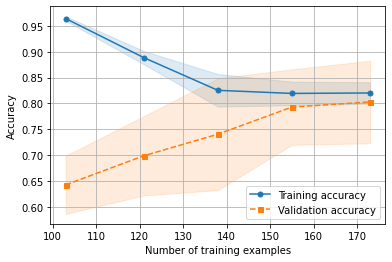

In [ ]:
print_learning_curve(gs_lr1.best_estimator_,df_train_X_sc1, df_train_y.apply(lambda x: 1 if x=="fire" else 0))

## Scenario 2: use first 2 principal components

In [ ]:
%%time
gs_lr2, cf=apply_model(lr,LR_PARAMS,df_train_X_pca,df_train_y,df_test_X_pca,df_test_y)

CPU times: user 95.3 ms, sys: 2.58 ms, total: 97.9 ms
Wall time: 200 ms


In [ ]:
print_grid_search_result(gs_lr2)

Best grid scores on validation set:
0.907 (+/-0.078) for {'md__C': 1, 'md__penalty': 'l2', 'md__solver': 'liblinear'}


In [ ]:
cf

,predicted not fire,predicted fire
true not fire,0.95,0.04
true fire,0.11,0.89


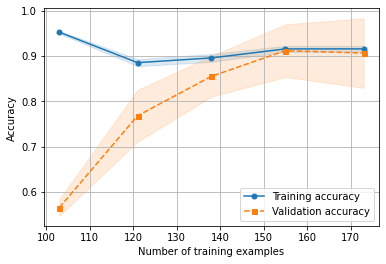

In [ ]:
print_learning_curve(gs_lr2.best_estimator_,df_train_X_pca, df_train_y.apply(lambda x: 1 if x=="fire" else 0))

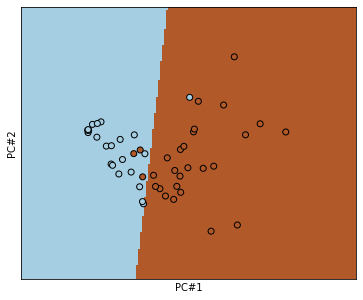

In [ ]:
decision_boundary(gs_lr2.best_estimator_,df_train_X_pca,df_test_X_pca,df_test_y.apply(lambda x: 1 if x=="fire" else 0))

##Scenario 3: Keep all features

In [ ]:
%%time
gs_lr3, cf=apply_model(lr,LR_PARAMS,df_train_X,df_train_y,df_test_X,df_test_y)

CPU times: user 92.4 ms, sys: 3.65 ms, total: 96 ms
Wall time: 185 ms


In [ ]:
print_grid_search_result(gs_lr3)

Best grid scores on validation set:
0.979 (+/-0.021) for {'md__C': 10, 'md__penalty': 'l1', 'md__solver': 'liblinear'}


In [ ]:
cf

,predicted not fire,predicted fire
true not fire,0.95,0.04
true fire,0.07,0.93


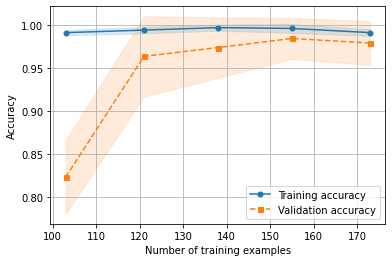

In [ ]:
print_learning_curve(gs_lr3.best_estimator_,df_train_X, df_train_y.apply(lambda x: 1 if x=="fire" else 0))

# KNN

K Nearest neighbours is a non linear classification algorithm. It classifies new samples according to the K nearest neigh-bours in the training set.  When a new samples has to be classified, the distance between the new sample and every trainingsample is computed.  Then the K closest samples are selected (k is an hyperparameter) and the new sample is labeled as theclass that is most present in the k training samples.  Another hyperparameter to set is the distance metrics (here minkowskidistance is used, where the power parameter p is selected though grid search), and the distance penalization (all k votes canwight the same or can have a penalization factor which grows with the distance with respect to the new sample)

In [ ]:
KNN_PARAMS = {
    'md__n_neighbors': [3,5,7,15],     #K
    'md__weights': ['uniform', 'distance'], #uniform weights. All points in each neighborhood are weighted equally, distance’ : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.
    'md__p': [1, 2, 10]     #parameter for the minkowski distance
}
knn=KNeighborsClassifier()

## Scenario 1: keep only raw Features

In [ ]:
%%time
gs_knn1, cf=apply_model(knn,KNN_PARAMS,df_train_X_sc1,df_train_y,df_test_X_sc1,df_test_y)


CPU times: user 251 ms, sys: 7.99 ms, total: 259 ms
Wall time: 1.18 s


In [ ]:
print_grid_search_result(gs_knn1)

Best grid scores on validation set:
0.772 (+/-0.096) for {'md__n_neighbors': 7, 'md__p': 2, 'md__weights': 'uniform'}


In [ ]:
cf

,predicted not fire,predicted fire
true not fire,0.77,0.23
true fire,0.25,0.75


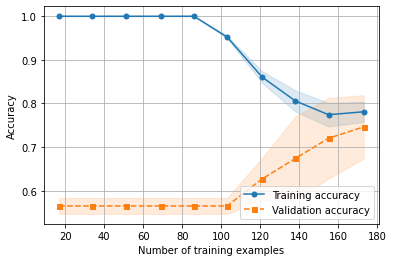

In [ ]:
print_learning_curve(gs_knn1.best_estimator_,df_train_X_sc1, df_train_y.apply(lambda x: 1 if x=="fire" else 0))

## Scenario 2: use first two principal components

In [ ]:
%%time
gs_knn2, cf=apply_model(knn,KNN_PARAMS,df_train_X_pca,df_train_y,df_test_X_pca,df_test_y)

CPU times: user 301 ms, sys: 5.1 ms, total: 306 ms
Wall time: 1.12 s


In [ ]:
print_grid_search_result(gs_knn2)

Best grid scores on validation set:
0.906 (+/-0.104) for {'md__n_neighbors': 15, 'md__p': 2, 'md__weights': 'distance'}


In [ ]:
cf

,predicted not fire,predicted fire
true not fire,0.95,0.04
true fire,0.11,0.89


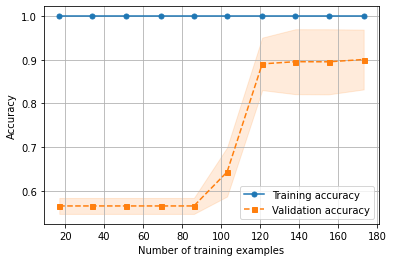

In [ ]:
print_learning_curve(gs_knn2.best_estimator_,df_train_X_pca, df_train_y.apply(lambda x: 1 if x=="fire" else 0))

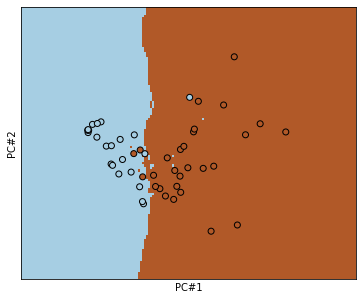

In [ ]:
decision_boundary(gs_knn2.best_estimator_,df_train_X_pca,df_test_X_pca,df_test_y.apply(lambda x: 1 if x=="fire" else 0))

##Scenario 3: Keep all features

In [ ]:
%%time
gs_knn3, cf=apply_model(knn,KNN_PARAMS,df_train_X,df_train_y,df_test_X,df_test_y)

CPU times: user 249 ms, sys: 9.32 ms, total: 258 ms
Wall time: 1.46 s


In [ ]:
print_grid_search_result(gs_knn3)

Best grid scores on validation set:
0.953 (+/-0.050) for {'md__n_neighbors': 5, 'md__p': 1, 'md__weights': 'distance'}


In [ ]:
cf

,predicted not fire,predicted fire
true not fire,0.95,0.04
true fire,0.04,0.96


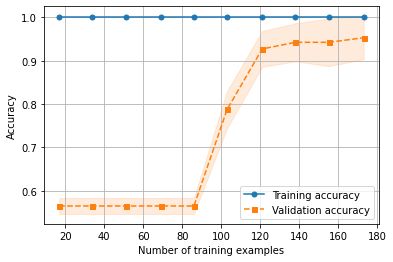

In [ ]:
print_learning_curve(gs_knn3.best_estimator_,df_train_X, df_train_y.apply(lambda x: 1 if x=="fire" else 0))

#SVM

Support vector machines are a linear binary classification algorithm that tries to find an hyperplane to separate the databy maximizing the margin between the hyperplane and the two sets of data themselves.  The term "support vector" refersto the the training points that lies on the margins.  Indeed solving the optimization problem for the margin maximizationshows that the contribution given by points that don’t lie on the margin is null; only the samples on the margin plays a rolein finding the solution and that’s why they are called support vector. This makes the SVM really robust with respect to outliers.

The  standard  approach  to  SVM  is  also  called  "Hard  margin  SVM"  as  it  doesn’t  allow  for  any  misclassification  oftraining data. In real world problems this is too restricting though, as perfect linear separability it’s really uncommon due tonoise and outliers. To solve this problem there exists a variation of the SVM model called "Soft margin SVM". Soft marginSVM introduces a new learnable parameter called "slack variable" which allows some points to violate the hard marginconstraint so that some data can be classified wrongly. Each slack variable is weighted by an hyperparameter (usually calledC) which is used to define how wide the incertainty area should be (the greater the value of C, the thinner the soft margin,the hard margin SVM can be see as a soft margin SVM with infinite C) This of course introduce a bit of uncertainty in themodel but makes it much more flexible and applicable to real world problems.

Most  of  real  world  problems  are  not  linearly  separable,  Nevertheless  SVM  can  still  be  applied  by  mapping  samplesdata  to  an  higher  dimensional  space  (through  a  mapping  function)  in  which  they  can  be  separated  linearly,  and  thenprojecting  them  back  on  the  original  space  after  the  separation  hyperplane  has  been  found  on  the  higher  dimensionalspace.  Finding a good feature mapper is not an easy task at all though.  Luckily, given that in SVM optimization problem doesn’t require the whole feature mapping expression but only the inner products of the feature map.  The inner product of the feature mapping function is called "kernel" and is defined asK(x1,x2) =φ(x1)Tφ(x2).  So to perform the feature mapping it is enough to substitute every inner product in the original SVM with the kernel function, this is called "kernel trick"For this report we analyze two kernels:
•  linear kernel:K(x1,x2) =x1·x2
  which is the standard setting without mapping
•  radial basis function (rbf) kernel:K(x1,x2) =exp(−γ(‖x1−x2‖2))
  where gamma is an hyperparameter which determines the area of influence  for each point, low gamma means great area of influence

In [ ]:
SVM_PARAMS = [
{
    'md__kernel': ['linear'],      
    'md__C': [0.1, 1, 10],    #soft margin parameter
}, 
{
    'md__kernel': ['rbf'],
    'md__C': [0.01, 0.1, 1, 10, 100],
    'md__gamma': [0.01, 0.1, 1, 10, 100], #rbf kernel parameter
}]

svm = svm.SVC(probability=True,random_state=SEED)

## Scenario 1: keep only raw Features

In [ ]:
%%time
gs_svm1, cf=apply_model(svm,SVM_PARAMS,df_train_X_sc1,df_train_y,df_test_X_sc1,df_test_y)

CPU times: user 277 ms, sys: 6.22 ms, total: 283 ms
Wall time: 1.26 s


In [ ]:
print_grid_search_result(gs_svm1)

Best grid scores on validation set:
0.798 (+/-0.073) for {'md__C': 100, 'md__gamma': 0.1, 'md__kernel': 'rbf'}


In [ ]:
cf

,predicted not fire,predicted fire
true not fire,0.77,0.23
true fire,0.11,0.89


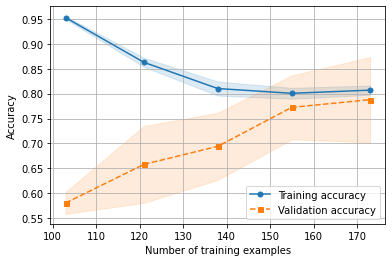

In [ ]:
print_learning_curve(gs_svm1.best_estimator_,df_train_X_sc1, df_train_y.apply(lambda x: 1 if x=="fire" else 0))

##Scenario 2: use first two principal components

In [ ]:
%%time
gs_svm2, cf=apply_model(svm,SVM_PARAMS,df_train_X_pca,df_train_y,df_test_X_pca,df_test_y)

CPU times: user 295 ms, sys: 9.47 ms, total: 304 ms
Wall time: 1.1 s


In [ ]:
print_grid_search_result(gs_svm2)

Best grid scores on validation set:
0.906 (+/-0.086) for {'md__C': 0.1, 'md__gamma': 1, 'md__kernel': 'rbf'}


In [ ]:
cf

,predicted not fire,predicted fire
true not fire,0.95,0.04
true fire,0.11,0.89


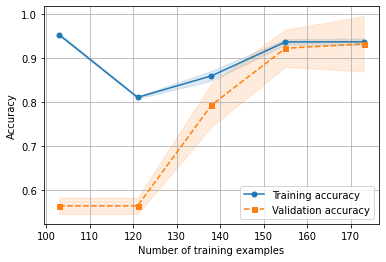

In [ ]:
print_learning_curve(gs_svm2.best_estimator_,df_train_X, df_train_y.apply(lambda x: 1 if x=="fire" else 0))

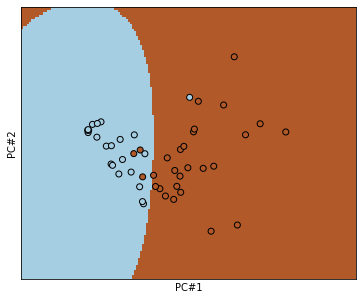

In [ ]:
decision_boundary(gs_svm2.best_estimator_,df_train_X_pca,df_test_X_pca,df_test_y.apply(lambda x: 1 if x=="fire" else 0))

##Scenario 3: Keep all features

In [ ]:
%%time
gs_svm3, cf=apply_model(svm,SVM_PARAMS,df_train_X,df_train_y,df_test_X,df_test_y)

CPU times: user 254 ms, sys: 1.89 ms, total: 255 ms
Wall time: 1.14 s


In [ ]:
print_grid_search_result(gs_svm3)

Best grid scores on validation set:
0.959 (+/-0.062) for {'md__C': 100, 'md__gamma': 1, 'md__kernel': 'rbf'}


In [ ]:
cf

,predicted not fire,predicted fire
true not fire,0.95,0.04
true fire,0.04,0.96


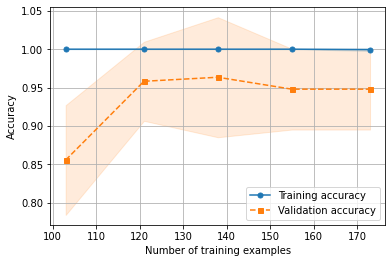

In [ ]:
print_learning_curve(gs_svm3.best_estimator_,df_train_X, df_train_y.apply(lambda x: 1 if x=="fire" else 0))

#Decision tree

Decision tree performs classification through a greedy top-down approach. At first a feature is selected and the training setis split in two subset according to a threshold value selected in the domain of the selected attribute. The attribute is selectedso that a performance measure is optimized. Then the process is repeated again on the two subset until either the maximumdepth of the tree is reached (this value is an hyperparameter) or optimization all the branches is above a certain threshold(also an hyperparameter). To perform classification on a testing sample the tree is traversed from the top to the bottom, goingon the right or left branch according to the feature and the threshold of that node with respect to the value that feature hasfor the sample data to classify. When a leaf is reached the sample is labeled according to the majority class in that leaf. Thefollowing optimization measures are considered:

•  Gini index:IG(p) =∑ji=1pi(1−pi)^2 where j is the number of classes and pi is the fraction of samples assigned toclass with respect to the total number of sample for the subset. it measures the total variance across all the classes for asubset. The purer a split, the better job it does in separating the classes.
•  Information gain:IG=H(p)−∑ki=1ninH(i)whereH(p)is the cross entropy defined as H(t)=−∑ji=1pilog2pi,withn,nithe number of samples in the subset and the number of sample of class i in that subset respectively

In [ ]:
DT_PARAMS = {
    'md__max_depth': [15, 25, 50],
    'md__max_features': ["sqrt"], # just sqrt is used because values of log2 and sqrt are very similar for our number of features (10-19)
    'md__criterion': ['gini', 'entropy'], #split criterion
    'md__min_samples_split': [6, 10, 14], #minimum amount of sample required to have a leaf node
}

dt = DecisionTreeClassifier(random_state=SEED)

In [ ]:
def plot_feature_importance(feature_importance, title):
    trace1 = go.Bar(
        x=feature_importance[:, 0],
        y=feature_importance[:, 1],
        marker = dict(color = not_fire_color),
        name='feature importance'
    )
    data = [trace1]
    layout = go.Layout(
        title=title,
        autosize=True,
        margin=go.layout.Margin(l=50, r=100, b=150),
        xaxis=dict(
            title='feature',
            tickangle=30
        ),
        yaxis=dict(
            title='feature importance',
            automargin=True,
        ),
    )
    fig = go.Figure(data=data, layout=layout)
    fig.show()

## Scenario 1: keep only raw features

In [ ]:
%%time
gs_dt1, cf=apply_model(dt,DT_PARAMS,df_train_X_sc1,df_train_y,df_test_X_sc1,df_test_y)

CPU times: user 269 ms, sys: 4.02 ms, total: 273 ms
Wall time: 505 ms


In [ ]:
print_grid_search_result(gs_dt1)

Best grid scores on validation set:
0.860 (+/-0.044) for {'md__criterion': 'entropy', 'md__max_depth': 25, 'md__max_features': 'sqrt', 'md__min_samples_split': 10}


In [ ]:
cf

,predicted not fire,predicted fire
true not fire,0.68,0.32
true fire,0.11,0.89


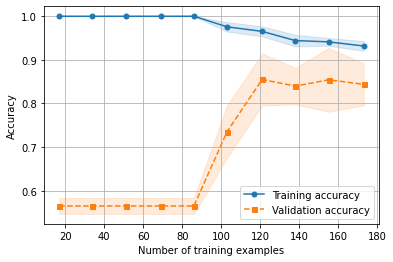

In [ ]:
print_learning_curve(gs_dt1.best_estimator_,df_train_X_sc1, df_train_y.apply(lambda x: 1 if x=="fire" else 0))

In [ ]:
feature_importance = np.array(sorted(zip(df_train_X_sc1.columns, gs_dt1.best_estimator_.named_steps['md'].feature_importances_), key=lambda x: x[1], reverse=True))
plot_feature_importance(feature_importance, "Feature importance in the decision tree (Scenario 1: raw features)")

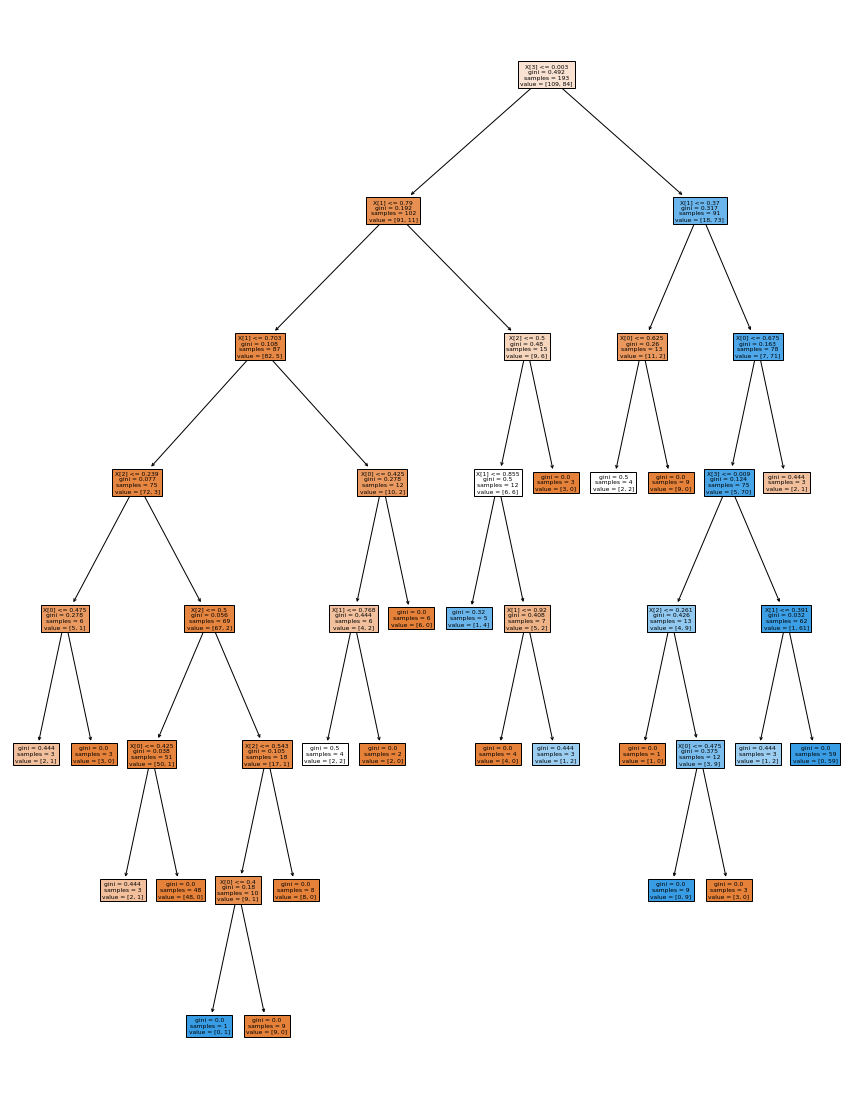

In [ ]:
plt.figure(figsize=(15,20))
clf = DecisionTreeClassifier(criterion="gini",
                             max_depth=15,
                             min_samples_split=6,
                             max_features="sqrt").fit(df_train_X_sc1, df_train_y)
tree.plot_tree(clf, filled=True)
plt.show()

##Scenario 2 : use first two principal components

In [ ]:
%%time
gs_dt2, cf=apply_model(dt,DT_PARAMS,df_train_X_pca,df_train_y,df_test_X_pca,df_test_y)

CPU times: user 269 ms, sys: 7.4 ms, total: 276 ms
Wall time: 526 ms


In [ ]:
print_grid_search_result(gs_dt2)

Best grid scores on validation set:
0.860 (+/-0.140) for {'md__criterion': 'entropy', 'md__max_depth': 50, 'md__max_features': 'sqrt', 'md__min_samples_split': 14}


In [ ]:
cf

,predicted not fire,predicted fire
true not fire,0.82,0.18
true fire,0.21,0.79


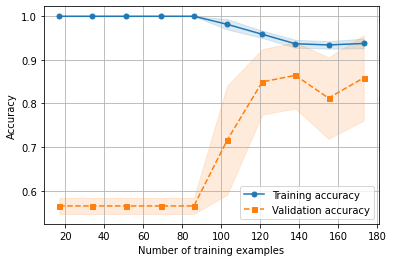

In [ ]:
print_learning_curve(gs_dt2.best_estimator_,df_train_X_pca, df_train_y.apply(lambda x: 1 if x=="fire" else 0))

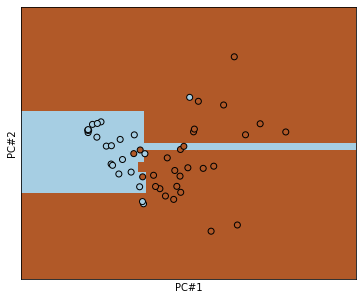

In [ ]:
decision_boundary(gs_dt2.best_estimator_,df_train_X_pca,df_test_X_pca,df_test_y.apply(lambda x: 1 if x=="fire" else 0))

##Scenario 3: keep all features

In [ ]:
%%time
gs_dt3, cf=apply_model(dt,DT_PARAMS,df_train_X,df_train_y,df_test_X,df_test_y)

CPU times: user 188 ms, sys: 6.72 ms, total: 195 ms
Wall time: 460 ms


In [ ]:
print_grid_search_result(gs_dt3)

Best grid scores on validation set:
0.969 (+/-0.051) for {'md__criterion': 'gini', 'md__max_depth': 15, 'md__max_features': 'sqrt', 'md__min_samples_split': 6}


In [ ]:
cf

,predicted not fire,predicted fire
true not fire,0.86,0.14
true fire,0.00,1.00


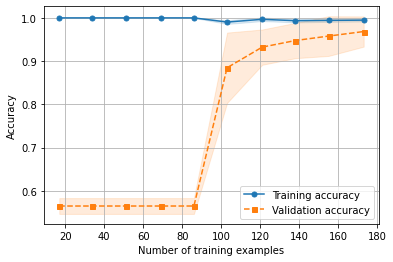

In [ ]:
print_learning_curve(gs_dt3.best_estimator_,df_train_X, df_train_y.apply(lambda x: 1 if x=="fire" else 0))

In [ ]:
feature_importance = np.array(sorted(zip(df_train_X.columns, gs_dt3.best_estimator_.named_steps['md'].feature_importances_), key=lambda x: x[1], reverse=True))
plot_feature_importance(feature_importance, "Feature importance in the decision (scenario 3: all features)")

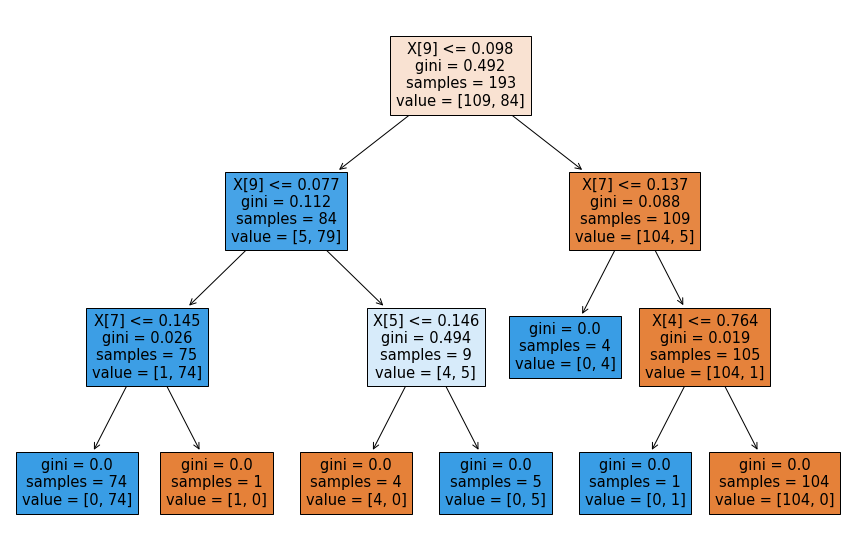

In [ ]:
plt.figure(figsize=(15,10))
clf = DecisionTreeClassifier(criterion="gini",
                             max_depth=15,
                             min_samples_split=6,
                             max_features="sqrt").fit(df_train_X, df_train_y)
tree.plot_tree(clf, filled=True)
plt.show()

# Random forest

Random  forest  are  an  evolution  of  decision  tree,  they  are  an  ensamble  method  meaning  that  many  decision  tree  aretrained (with the usual algorithm) and then the final labelling is done through majority voting.  The trees are trained on aunique dataset of fixed size created by random sampling with replacement from the training dataset. This technique is calledBagging and it’s used to reduce variance and as a consequence make the trees more accurate.

In [ ]:
RF_PARAMS = {
    'md__max_depth': [15, 25, 50], 
    'md__max_features': ["sqrt"], 
    'md__criterion': ['gini', 'entropy'],
    'md__n_estimators': [10,30,50,100] #number of trees in the fores
}

rf = RandomForestClassifier(random_state=SEED)

## Scenario 1: keep only raw features

In [ ]:
%%time
gs_rf1, cf=apply_model(rf,RF_PARAMS,df_train_X_sc1,df_train_y,df_test_X_sc1,df_test_y)

CPU times: user 458 ms, sys: 13.7 ms, total: 472 ms
Wall time: 8.52 s


In [ ]:
print_grid_search_result(gs_rf1)

Best grid scores on validation set:
0.871 (+/-0.091) for {'md__criterion': 'entropy', 'md__max_depth': 50, 'md__max_features': 'sqrt', 'md__n_estimators': 50}


In [ ]:
cf

,predicted not fire,predicted fire
true not fire,0.73,0.27
true fire,0.07,0.93


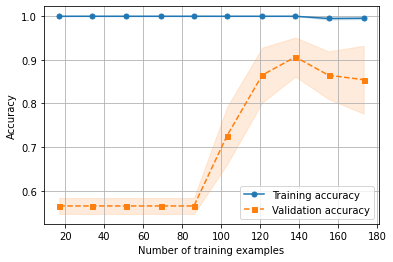

In [ ]:
print_learning_curve(gs_rf1.best_estimator_,df_train_X_sc1, df_train_y.apply(lambda x: 1 if x=="fire" else 0))

In [ ]:
feature_importance = np.array(sorted(zip(df_train_X_sc1.columns, gs_rf1.best_estimator_.named_steps['md'].feature_importances_), key=lambda x: x[1], reverse=True))
plot_feature_importance(feature_importance, "Feature importance in the decision tree (Scenario 1: raw features)")

##Scenario 2: use first two principal components

In [ ]:
%%time
gs_rf2, cf=apply_model(rf,RF_PARAMS,df_train_X_pca,df_train_y,df_test_X_pca,df_test_y)

CPU times: user 422 ms, sys: 9.15 ms, total: 431 ms
Wall time: 8.34 s


In [ ]:
print_grid_search_result(gs_rf2)

Best grid scores on validation set:
0.912 (+/-0.072) for {'md__criterion': 'gini', 'md__max_depth': 25, 'md__max_features': 'sqrt', 'md__n_estimators': 50}


In [ ]:
cf

,predicted not fire,predicted fire
true not fire,0.86,0.14
true fire,0.11,0.89


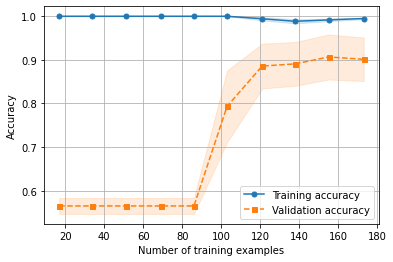

In [ ]:
print_learning_curve(gs_rf2.best_estimator_,df_train_X_pca, df_train_y.apply(lambda x: 1 if x=="fire" else 0))

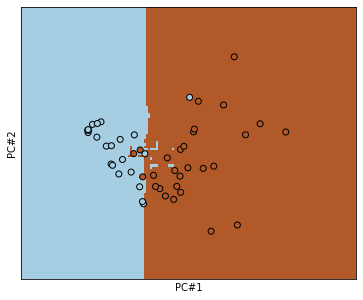

In [ ]:
decision_boundary(gs_rf2.best_estimator_,df_train_X_pca,df_test_X_pca,df_test_y.apply(lambda x: 1 if x=="fire" else 0))

##Scenario 3: keep all features

In [ ]:
%%time
gs_rf3, cf=apply_model(rf,RF_PARAMS,df_train_X,df_train_y,df_test_X,df_test_y)

CPU times: user 416 ms, sys: 13.1 ms, total: 429 ms
Wall time: 8.34 s


In [ ]:
print_grid_search_result(gs_rf3)

Best grid scores on validation set:
0.979 (+/-0.039) for {'md__criterion': 'gini', 'md__max_depth': 15, 'md__max_features': 'sqrt', 'md__n_estimators': 30}


In [ ]:
cf

,predicted not fire,predicted fire
true not fire,0.95,0.04
true fire,0.04,0.96


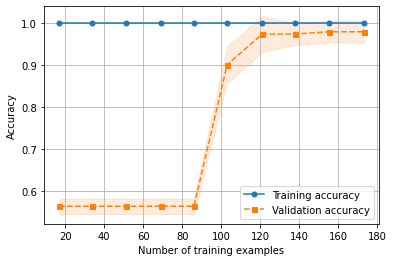

In [ ]:
print_learning_curve(gs_rf3.best_estimator_,df_train_X, df_train_y.apply(lambda x: 1 if x=="fire" else 0))

In [ ]:
feature_importance = np.array(sorted(zip(df_train_X.columns, gs_rf3.best_estimator_.named_steps['md'].feature_importances_), key=lambda x: x[1], reverse=True))
plot_feature_importance(feature_importance, "Feature importance in the decision tree (Scenario 3: all features)")

#Comparison

In [ ]:
def draw_roc_curves(classifiers,names,X_train,y_train,X_test,y_test,sc):
  result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

  # Train the models and record the results
  i=0
  for cls in classifiers:
      model = cls.fit(X_train, y_train)
      yproba = model.predict_proba(X_test)[::,1]
      
      fpr, tpr, _ = roc_curve(y_test,  yproba)
      auc = roc_auc_score(y_test, yproba)
      result_table = result_table.append({'classifiers':names[i],
                                          'fpr':fpr, 
                                          'tpr':tpr, 
                                          'auc':auc}, ignore_index=True)
      i=i+1

  # Set name of the classifiers as index labels
  result_table.set_index('classifiers', inplace=True)
  fig = plt.figure(figsize=(8,6))

  
  for i in result_table.index:
      plt.plot(result_table.loc[i]['fpr'], 
              result_table.loc[i]['tpr'], 
              label=i+", AUC="+ str( format(result_table.loc[i]['auc'],'.3f')))
      
  plt.plot([0,1], [0,1], color='orange', linestyle='--')

  plt.xticks(np.arange(0.0, 1.1, step=0.1))
  plt.xlabel("Flase Positive Rate", fontsize=15)

  plt.yticks(np.arange(0.0, 1.1, step=0.1))
  plt.ylabel("True Positive Rate", fontsize=15)

  plt.title('ROC Curve Analysis Scenario'+sc, fontweight='bold', fontsize=15)
  plt.legend(prop={'size':13}, loc='lower right')

  plt.show()


In [ ]:
names=["LogisticRegression","KNN","SVM","Decision tree","Random forest"]

## ROC curve Scenario 1

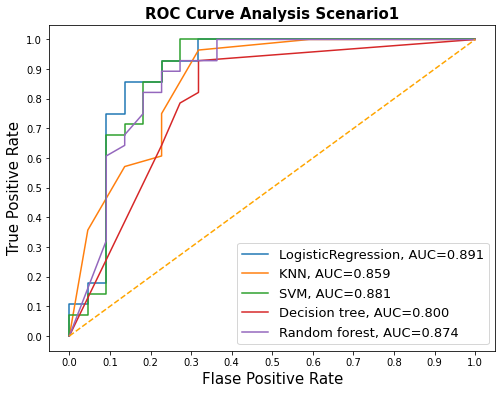

In [ ]:
classifiers1=[gs_lr1.best_estimator_,gs_knn1.best_estimator_,
            gs_svm1.best_estimator_,gs_dt1.best_estimator_,gs_rf1.best_estimator_]

draw_roc_curves(classifiers1,names,df_train_X_sc1,df_train_y.apply(lambda x: 1 if x=="fire" else 0),
                df_test_X_sc1,df_test_y.apply(lambda x: 1 if x=="fire" else 0),"1")

## ROC curve scenario 2

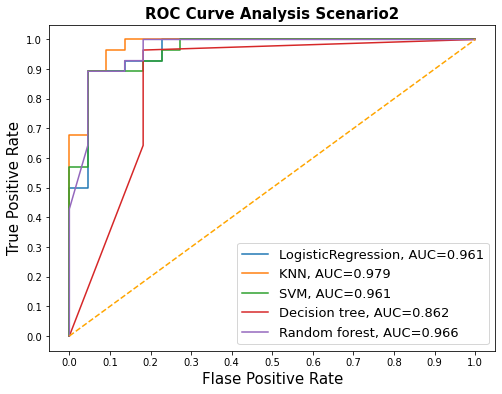

In [ ]:
classifiers2=[gs_lr2.best_estimator_,gs_knn2.best_estimator_,
            gs_svm2.best_estimator_,gs_dt2.best_estimator_,gs_rf2.best_estimator_]

draw_roc_curves(classifiers2,names,df_train_X_pca,df_train_y.apply(lambda x: 1 if x=="fire" else 0),
                df_test_X_pca,df_test_y.apply(lambda x: 1 if x=="fire" else 0),"2")

## ROC curve scenario 3

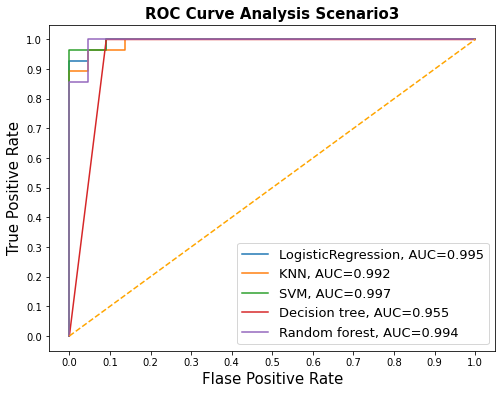

In [ ]:
classifiers3=[gs_lr3.best_estimator_,gs_knn3.best_estimator_,
            gs_svm3.best_estimator_,gs_dt3.best_estimator_,gs_rf3.best_estimator_]

draw_roc_curves(classifiers3,names,df_train_X,df_train_y.apply(lambda x: 1 if x=="fire" else 0),
                df_test_X,df_test_y.apply(lambda x: 1 if x=="fire" else 0),"3")

In [ ]:
def print_metrics(classifiers,names,X_test,y_test):
  accs = []
  recalls = []
  precision = []
  results_table = pd.DataFrame(columns=["accuracy", "precision", "recall", "f1", ])
  for (i, clf), name in zip(enumerate(classifiers), names):
      y_pred = clf.predict(X_test)
      row = []
      row.append(accuracy_score(y_test, y_pred))
      row.append(precision_score(y_test, y_pred))
      row.append(recall_score(y_test, y_pred))
      row.append(f1_score(y_test, y_pred))
      row = ["%.3f" % r for r in row]
      results_table.loc[name] = row
  return results_table

##Metrics scenario 1

In [ ]:
print_metrics(classifiers1,names,df_test_X_sc1,df_test_y.apply(lambda x: 1 if x=="fire" else 0))

,accuracy,precision,recall,f1
LogisticRegression,0.840,0.833,0.893,0.862
KNN,0.760,0.808,0.750,0.778
SVM,0.840,0.833,0.893,0.862
Decision tree,0.800,0.781,0.893,0.833
Random forest,0.840,0.812,0.929,0.867


## Metrics scanario 2

In [ ]:
print_metrics(classifiers2,names,df_test_X_pca,df_test_y.apply(lambda x: 1 if x=="fire" else 0))

,accuracy,precision,recall,f1
LogisticRegression,0.920,0.962,0.893,0.926
KNN,0.920,0.962,0.893,0.926
SVM,0.920,0.962,0.893,0.926
Decision tree,0.800,0.846,0.786,0.815
Random forest,0.880,0.893,0.893,0.893


## Metrics scenario 3

In [ ]:
print_metrics(classifiers3,names,df_test_X,df_test_y.apply(lambda x: 1 if x=="fire" else 0))

,accuracy,precision,recall,f1
LogisticRegression,0.940,0.963,0.929,0.945
KNN,0.960,0.964,0.964,0.964
SVM,0.960,0.964,0.964,0.964
Decision tree,0.940,0.903,1.000,0.949
Random forest,0.960,0.964,0.964,0.964


#Conclusions

In this report a dataset of algerian forest fire has been analyzed to understand which features are the most relevant for forest fire detection and which models can be applied in order to predict such an event.
Through a series of experiments and evaluation it was found that FWI indexes are not simply an aggregation of raw features collected by the sensors but they actually introduce some insight on the problem allowing the models to perform better. It was also shown that applying PCA on this problem allows to simplifying it without loosing too much on performance an therefore it should be taken into consideration in those settings when computational power and storage capabilities are critical factors, such as a smart sensor directly on the field. In conclusion it seems to be  possible to apply various machine learning  models and algorithm to predict the possible outburst of a forest fire, even implementing more models at the same and use a majority voting system could result in even better and more robust performance.